# Figures Three & Eight: MHD Model Results

- Top Panels: comparison of radial cuts of modeled observables with in-situ measurements
    - velocity
    - density
    - radial magnetic field
- Bottom Panel: comparison of MHD and PFSS footpoints
    - longitude vs. latitude plot
    - correlation plot

## Imports

In [1]:
import os

import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.interpolate import interp1d

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.ticker import MaxNLocator

import datetime
import astrospice

from mhd.psipy.model import MASOutput

import tools.utilities as utils

import astropy.units as u
import sunpy.coordinates as scoords
for sc in ['psp','solar orbiter'] : kernels = astrospice.registry.get_kernels(sc,'predict') 

# COLORS
c = ['#ae017e','#085A99',  '#c98000'] # darker colors
lightc = ['#FCA4C4',  '#8FD3F4', '#FFCC70'] # lighter colors
fcol = 'mistyrose'
sacol='lavender'
sacol = 'violet'
f2col = 'lightgreen'
hcol = 'lightblue'
aa = 0.6
lw=2
clon = '#ae017e'
clat = '#085A99'
rcol = 'dimgrey'
cmaps = ['RdPu', 'cool', 'Wistia', 'spring']

# REGIONS
loc_hcs = [113, 116]
fsw2 = [125, 135]
sasw = [175, 185]
fsw = [70, 85]

# DIRECTORIES
IMG_DIR = './figures'
DF_DIR = './results'
PlotDir = '/Users/tamarervin/mplstyle/'
RES_DIR = 'results'

# PLOT STYLING
plot_style = os.path.join(PlotDir, 'figure_series.mplstyle')
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.cal'] = 'Helvetica Neue LT Pro'
plt.rcParams.update({'font.size': 18})
plt.style.use(plot_style)

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

/Users/tamarervin/miniconda3/envs/analysis/lib/python3.11/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

## Data

In [2]:
# ### READ IN DATA ###
parker, parkerdownt, parkerdownl, pss, orbiter, orbiterdownl, orbiterdownt, oss, his_orbiter, his_orbiterdownt, his_orbiterdownl = utils.read_data(RES_DIR, sigma_time=20)

### DEFINE REGIONS ###
lon_footpoints = parker.sslon
hhcs = np.logical_and(lon_footpoints >= loc_hcs[0], lon_footpoints <=loc_hcs[1])
salf = np.logical_and(lon_footpoints >=sasw[0], lon_footpoints <=sasw[1])
fast = np.logical_and(lon_footpoints >=fsw[0], lon_footpoints <=fsw[1])
fast2 = np.logical_and(lon_footpoints >=fsw2[0], lon_footpoints <=fsw2[1])

/Users/tamarervin/publications/e11_ch/tools/utilities.py:180: FutureWarning: 'loffset' in .resample() and in Grouper() is deprecated.

>>> df.resample(freq="3s", loffset="8H")

becomes:

>>> from pandas.tseries.frequencies import to_offset
>>> df = df.resample(freq="3s").mean()
>>> df.index = df.index.to_timestamp() + to_offset("8H")

  pss = parker.resample(sigma_bin, closed='left', label='left', loffset=sigma_bin / 2).mean()
/Users/tamarervin/publications/e11_ch/tools/utilities.py:180: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pss = parker.resample(sigma_bin, closed='left', label='left', loffset=sigma_bin / 2).mean()
/Users/tamarervin/publications/e11_ch/tools/utilities.py:189: FutureWarning: 'loffset' in .resample() and in Grouper() is deprecated.

>>> df.resample(freq="3s", loffset="8H")


## Parker Trajectory

Functions from https://github.com/STBadman/PSP_E10_Sources/blob/main/helpers.py

In [3]:
from astropy.coordinates import SkyCoord

@u.quantity_input
def ballistic_delta_long(r:u.R_sun,
               r_inner=2.0*u.R_sun,
               vsw=360.*u.km/u.s,
               omega_sun=14.713*u.deg/u.d,
               ):
    """ 
    Ballistic longitudinal shift of a Parker spiral connecting two
    points at radius r and r_inner, for a solar wind speed vsw. Solar
    rotation rate is also tunable
    """
    return (omega_sun * (r - r_inner) / vsw)

def ballistically_project(skycoord,r_inner = 2.0*u.R_sun, vr_arr=None) :
    """
    Given a `SkyCoord` of a spacecraft trajectory in the Carrington frame,
    with `representation_type="spherical"`, and optionally an array of
    measured solar wind speeds at the same time intervals of the trajectory,
    return a SkyCoord for the trajectory ballistically projected down to 
    `r_inner` via a Parker spiral of the appropriate curvature. When `vr_arr`
    is not supplied, assumes wind speed is everywhere 360 km/s
    """
    if vr_arr is None : vr_arr = np.ones(len(skycoord))*360*u.km/u.s
    lons_shifted = skycoord.lon + ballistic_delta_long(skycoord.radius,
                                             r_inner=r_inner,
                                             vsw=vr_arr
                                            )
    return SkyCoord(
        lon = lons_shifted, 
        lat = skycoord.lat,
        radius = r_inner * np.ones(len(skycoord)),
        representation_type="spherical",
        frame = skycoord.frame
    )

In [4]:
# get carrington locations at these timestamps for each instrument
### Create SkyCoord for PSP in the inertial (J2000) frame
psp_inertial = astrospice.generate_coords(
    'SOLAR PROBE PLUS', parker.Time

)
### Transform to solar co-rotating frame 
psp_carrington = psp_inertial.transform_to(
    scoords.HeliographicCarrington(observer="self")
)

# projection
psp_projected = ballistically_project(psp_carrington,vr_arr=(np.array(parker.vr))*u.km/u.s, r_inner=2.0*u.Rsun)

### Create MHD Dataframe for Tracing

In [5]:
### CREATE MHD DATAFRAME
dt_start,dt_end = datetime.datetime(2022,2,23),datetime.datetime(2022,3,1)
dt_common = utils.gen_dt_arr(dt_start, dt_end, cadence_days=1/96)
ts_common = np.array([dt.timestamp() for dt in dt_common])

# get carrington locations at these timestamps for each instrument
### Create SkyCoord for PSP in the inertial (J2000) frame
psp_inertial = astrospice.generate_coords(
    'SOLAR PROBE PLUS', dt_common

)
### Transform to solar co-rotating frame 
psp_carrington = psp_inertial.transform_to(
    scoords.HeliographicCarrington(observer="self")
)

# get velocity
psp_vr_ts = [int(dt.timestamp()) for dt in parker.Time]
psp_vr_common = interp1d(psp_vr_ts,parker.vr,bounds_error=False)(ts_common)*u.km/u.s
    
# projection
psp_proj_common = ballistically_project(psp_carrington,vr_arr=psp_vr_common, r_inner=2.0*u.Rsun)
psp_mhd = ballistically_project(psp_carrington,vr_arr=psp_vr_common, r_inner=19.5*u.Rsun)

In [7]:
### CREATE DATAFRAME
# MHD footpoints
psp_vr_ts = [int(dt.timestamp()) for dt in parker.Time]
psp_vr_common = interp1d(psp_vr_ts,parker.vr,bounds_error=False)(ts_common)*u.km/u.s
psp_mhd = ballistically_project(psp_carrington,r_inner=19.5*u.R_sun,vr_arr=psp_vr_common)

r = psp_mhd.radius.to(u.solRad)
t = np.pi/2*u.rad - psp_mhd.lat.to(u.rad)
p = psp_mhd.lon.to(u.rad)

rtp = pd.DataFrame(data={'r':r, 't':t, 'p':p})
rtp = rtp.dropna()
rtp.to_csv('mhd/mhd_trace.dat', sep=' ', index=False)
rtp
# mhd_trace = mhd_trace.dropna()
# mhd_trace.to_csv('mhd/mhd_trace.dat', sep=' ', index=None)
# pd.read_csv('mhd/mhd_trace.dat')  
# mhd_trace
        
### TRACING
# trace -geom rtp -cat  /Users/tamarervin/publications/e11_ch/mhd/catalog_mhd.dat -lp /Users/tamarervin/publications/e11_ch/mhd/mhd_trace.dat -l 100 -ds 0.0005 -dir b -final /Users/tamarervin/publications/e11_ch/mhd/footpoint-locations.dat


,r,t,p
0,19.5,1.529104,0.957046
1,19.5,1.529235,0.953309
2,19.5,1.529367,0.922280
3,19.5,1.529499,0.932021
4,19.5,1.529633,0.937986
...,...,...,...
539,19.5,1.567262,3.438148
540,19.5,1.567121,3.457219
541,19.5,1.566980,3.455824
542,19.5,1.566840,3.451934


,r,t,p
0,1.0,1.904374,0.668770
1,1.0,1.903898,0.668132
2,1.0,1.900099,0.662828
3,1.0,1.901252,0.664493
4,1.0,1.901990,0.665510
...,...,...,...
539,1.0,1.252106,3.797894
540,1.0,1.248132,3.804473
541,1.0,1.248344,3.804019
542,1.0,1.249021,3.802716


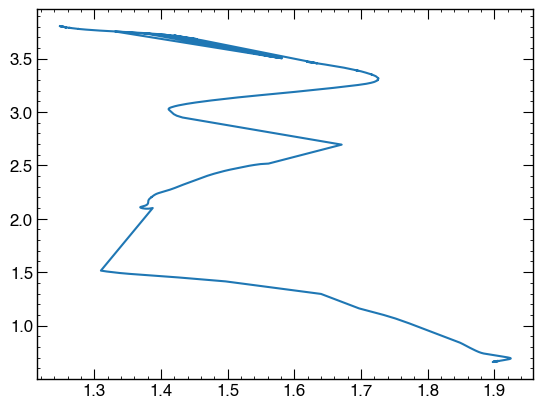

In [8]:
# PFSS/MHD data
tracerdf = pd.read_csv(os.path.realpath('mhd/footpoint-locations.dat'), sep='\s+') 
so_tracerdf = pd.read_csv(os.path.realpath('mhd/so_mhd_footpoints.dat'), sep='\s+')
pfss = pd.read_csv(os.path.realpath('results/pfss_02242022.csv'))
parkerdownl = utils.lon_bin(parker, counts=1, vv='lon')
plt.plot(tracerdf.t, tracerdf.p)
tracerdf

## MHD Plot

In [9]:
# read in mhd data
corona_model = MASOutput("mhd/hmi_02_24_2022/") 
cbr=corona_model['br']
cbt=corona_model['bp']
cbn=corona_model['bt']
crho = corona_model['rho']
cvr = corona_model['vr']
cvt = corona_model['vp']
cvn = corona_model['vt']
cp = corona_model['p']
cjr = corona_model['jr']
cjt = corona_model['jp']
cjn = corona_model['jt']

In [10]:
# resample the coordinates
rad = psp_carrington.radius
vr_sampled = cvr.sample_at_coords(psp_carrington.lon, psp_carrington.lat, rad)
rho_sampled = crho.radial_normalized(2).sample_at_coords(psp_carrington.lon, psp_carrington.lat, rad)
br_sampled = cbr.radial_normalized(2).sample_at_coords(psp_carrington.lon, psp_carrington.lat, rad)

/Users/tamarervin/publications/e11_ch/mhd/psipy/model/variable.py:454: UserWarning: At least one sample coordinate is outside bounds (1.0, 30.0) in r dimension. Sample coordinate min/max values are (13.27858933120552, 39.63627773685494).
  warnings.warn(
/Users/tamarervin/publications/e11_ch/mhd/psipy/model/variable.py:454: UserWarning: At least one sample coordinate is outside bounds (0.9995602369308472, 30.511646270751953) in r dimension. Sample coordinate min/max values are (13.27858933120552, 39.63627773685494).
  warnings.warn(


### Different Source Surface Heights

In [12]:
import tools.pfss_funcs as pfss_funcs
import tools.utilities as utils
filepath = 'adapt40311_03k012_202202240000_i00005600n1.fts.gz'


In [13]:
RSS = [1.5, 2.0, 2.50, 3.0, 3.5]
pfss_lon, pfss_lat = [], []
ss_df = pd.DataFrame()
for i, rss in enumerate(RSS):
    # run PFSS model
    pfss_model = pfss_funcs.adapt2pfsspy(filepath,rss)

    # trace PFSS lines
    flines = pfss_funcs.pfss2flines(pfss_model)

    # get Br at the source surface from the pfss model
    pfss_br = pfss_model.source_surface_br

    # get HCS
    hcs = pfss_model.source_surface_pils[0]
    
    # get field lines
    psp_ss = ballistically_project(psp_carrington,vr_arr=psp_vr_common, r_inner=rss*u.Rsun)
    fpsp = pfss_funcs.pfss2flines(pfss_model, skycoord_in=psp_ss)

    # add column to dataframe
    pfss_lon.append(fpsp.open_field_lines.solar_feet.lon.value)
    pfss_lat.append(fpsp.open_field_lines.solar_feet.lat.value)

    # print 
    print('Finished with source surface height:', rss)

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: dsun_obs,crln_obs,crlt_obs
 [sunpy.map.mapbase]
/Users/tamarervin/miniconda3/envs/analysis/lib/python3.11/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(
/Users/tamarervin/miniconda3/envs/analysis/lib/python3.11/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(
For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: dsun_obs,crln_obs,crlt_obs
 [sunpy.map.mapbase]


Finished with source surface height: 1.5
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


/Users/tamarervin/miniconda3/envs/analysis/lib/python3.11/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(
/Users/tamarervin/miniconda3/envs/analysis/lib/python3.11/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(
For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: dsun_obs,crln_obs,crlt_obs
 [sunpy.map.mapbase]


Finished with source surface height: 2.0
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


/Users/tamarervin/miniconda3/envs/analysis/lib/python3.11/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(
/Users/tamarervin/miniconda3/envs/analysis/lib/python3.11/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(
For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: dsun_obs,crln_obs,crlt_obs
 [sunpy.map.mapbase]


Finished with source surface height: 2.5
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


/Users/tamarervin/miniconda3/envs/analysis/lib/python3.11/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(
/Users/tamarervin/miniconda3/envs/analysis/lib/python3.11/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(
For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: dsun_obs,crln_obs,crlt_obs
 [sunpy.map.mapbase]


Finished with source surface height: 3.0
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


/Users/tamarervin/miniconda3/envs/analysis/lib/python3.11/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(


Finished with source surface height: 3.5


/Users/tamarervin/miniconda3/envs/analysis/lib/python3.11/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(


### Figure

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Figure 3 Saved!


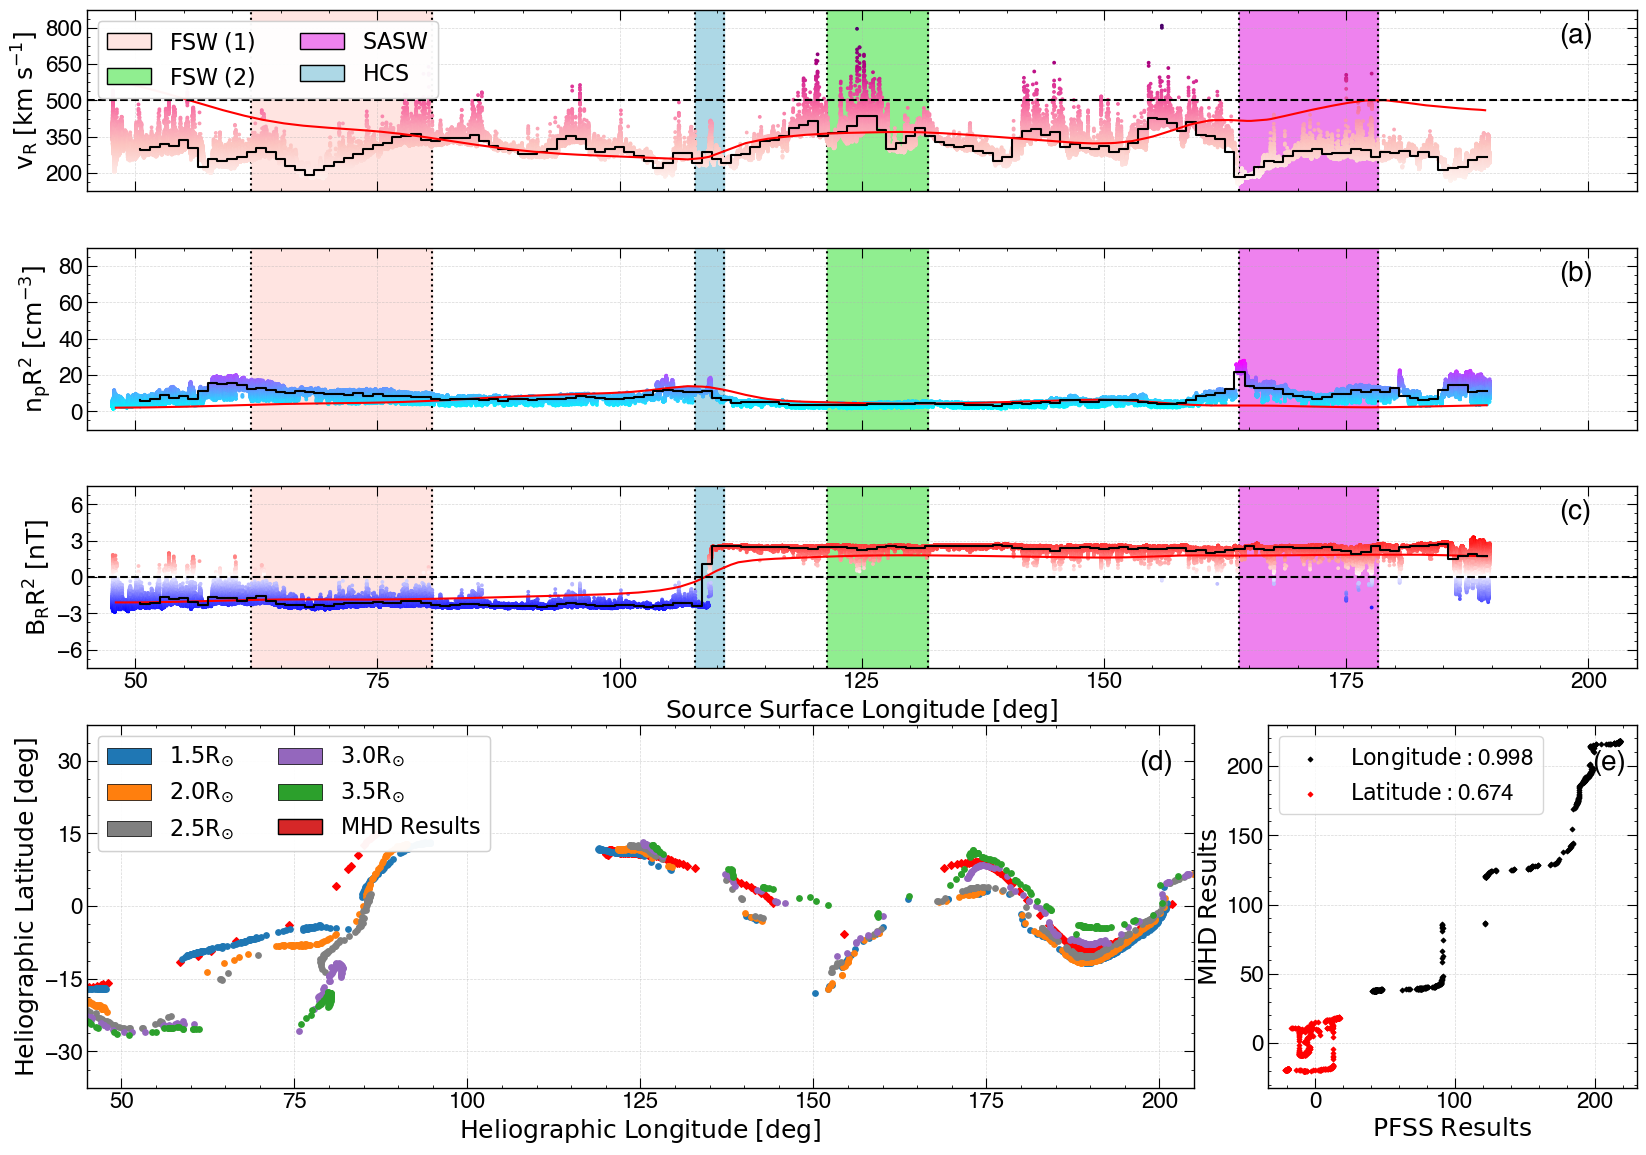

In [14]:
# plot in-situ data against the model
fig = plt.figure(figsize=(20, 14))
grid = plt.GridSpec(4, 2, height_ratios=[1, 1, 1, 2], width_ratios=[3, 1], wspace=0.1, hspace=0.25)

# create plots
ax1 = fig.add_subplot(grid[0, :])
ax2 = fig.add_subplot(grid[1, :])
ax3 = fig.add_subplot(grid[2, :])
ax4 = fig.add_subplot(grid[3, 0])
ax5 = fig.add_subplot(grid[3, 1])

# velocity
ax = ax1
ax.scatter(parker.lon, parker.vr, cmap='RdPu', c=parker.vr, s=3, label=r'$\rm Raw \; Data$')
ax.step(parkerdownl.lon, parkerdownl.vr, color='black', label=r'$\rm Binned \; Data$')
ax.plot(psp_carrington.lon, vr_sampled, color='red', label=r'$\rm MHD \; Results$')
ax.set(ylim=(125, 875), yticks=np.arange(200, 801, step=150))
ax.set_ylabel(ylabel=r'$\rm v_R \; [km \; s^{-1}]$', fontsize=18)
ax.set_xticklabels([])
ax.axhline(500, color='k', linestyle='dashed')

### LEGEND 
fswp = mpatches.Patch(edgecolor='k', facecolor=fcol, label=r'$\rm FSW \; (1)$')
fsw2p = mpatches.Patch(edgecolor='k', facecolor=f2col,  label=r'$\rm FSW \; (2)$')
saswp = mpatches.Patch(edgecolor='k', facecolor=sacol,  label=r'$\rm SASW$')
hcsp = mpatches.Patch(edgecolor='k', facecolor=hcol,  label=r'$\rm HCS$')
leg0 = ax.legend(handles=[fswp, fsw2p, saswp, hcsp], loc='upper left', fontsize=16, ncols=2)
ax.add_artist(leg0)

# density
ax = ax2
ax.plot(psp_carrington.lon, rho_sampled*(1e-5), color='red')
ax.scatter(parker.lon, parker.NpR2, cmap='cool', c=parker.NpR2, s=3)
ax.step(parkerdownl.lon, parkerdownl.NpR2, color='black')
ax.set(ylim=(-10, 90), yticks=np.arange(0, 81, step=20))
ax.set_xticklabels([])
ax.set_ylabel(r'$\rm n_p R^2 \; [cm^{-3}]$', fontsize=18)

# magnetic field
ax = ax3
ax.plot(psp_carrington.lon, br_sampled*2, color='red')
im = ax.scatter(parker.lon, parker.BrR2, cmap='bwr', c=parker.BrR2, s=3)
ax.step(parkerdownl.lon, parkerdownl.BrR2, color='black')
ax.set(ylim=(-7.5, 7.5), yticks=np.arange(-6, 6.1, step=3))
ax.set_xlabel(xlabel=r'$\rm Source \; Surface \; Longitude \; [deg]$', fontsize=18)
ax.set_ylabel(ylabel=r'$\rm B_R R^2 \; [nT]$', fontsize=18)
ax.axhline(0, color='k', linestyle='dashed')

# Shade regions
panel_labels=['(a)', '(b)', '(c)']
for i, ax in enumerate([ax1, ax2, ax3]):
    ax.tick_params(axis='both', which='major', labelsize=16) 
    # shade interesting regions
    ### ADD REGIONS
    regions = [
        (parker[hhcs].lon.iloc[0], parker[hhcs].lon.iloc[-1], hcol),
        (parker[salf].lon.iloc[0], parker[salf].lon.iloc[-1], sacol),
        (parker[fast].lon.iloc[0], parker[fast].lon.iloc[-1], fcol),
        (parker[fast2].lon.iloc[0], parker[fast2].lon.iloc[-1], f2col)
    ]

    lines = [
        parker[hhcs].lon.iloc[0],
        parker[hhcs].lon.iloc[-1],
        parker[salf].lon.iloc[0],
        parker[salf].lon.iloc[-1],
        parker[fast].lon.iloc[0],
        parker[fast].lon.iloc[-1],
        parker[fast2].lon.iloc[0],
        parker[fast2].lon.iloc[-1]
    ]

    ### PLOT LINES AND REGIONS
    for line in lines:
        ax.axvline(line, color='k', linestyle='dotted', zorder=-2)

    for region in regions:
        ax.axvspan(region[0], region[1], color=region[2], zorder=-3)

    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
    ax.text(0.95, 0.93, panel_labels[i], transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')

## SCATTER
mlat = 90 - tracerdf.t*u.rad.to(u.deg)
ax4.scatter(tracerdf.p*u.rad.to(u.deg), mlat, c='red', s=15, label=r'$\rm MHD \; Results$', marker='D')
ax4.set_xlabel(r'$\rm Heliographic \; Longitude \; [deg]$', fontsize=18)
ax4.set_ylabel(r'$\rm Heliographic \; Latitude \; [deg]$', fontsize=18)
ax4.legend(fontsize=16, loc='upper left')
ax4.set(ylim=(-37.5, 37.5), yticks=np.arange(-30, 31, step=15))
ax4.tick_params(axis='both', which='major', labelsize=16) 
ax4.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
ax4.text(0.95, 0.93, '(d)', transform=ax4.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')

### plot different heights
ax = ax4
pfss_col = ['tab:blue', 'tab:orange', 'grey', 'tab:purple', 'tab:green']
for i, ll in enumerate(pfss_lon):
    ax.scatter(pfss_lon[i], pfss_lat[i], c=pfss_col[i], s=15) 

### LEGEND ###
p15 = mpatches.Patch(facecolor=pfss_col[0], edgecolor='k', linewidth=0.5, label=r'$\rm 1.5 R_{\odot}$')
p20 = mpatches.Patch(facecolor=pfss_col[1], edgecolor='k', linewidth=0.5, label=r'$\rm 2.0 R_{\odot}$')
p25 = mpatches.Patch(facecolor=pfss_col[2], edgecolor='k', linewidth=0.5, label=r'$\rm 2.5 R_{\odot}$')
p30 = mpatches.Patch(facecolor=pfss_col[3], edgecolor='k', linewidth=0.5, label=r'$\rm 3.0 R_{\odot}$')
p35 = mpatches.Patch(facecolor=pfss_col[4], edgecolor='k', linewidth=0.5, label=r'$\rm 3.5 R_{\odot}$')
mp = mpatches.Patch(facecolor='tab:red', edgecolor='k',  label=r'$\rm MHD \; Results$')
leg0 = ax.legend(handles=[p15, p20, p25, p30, p35, mp], loc='upper left', fontsize=16, ncol=2)
ax.add_artist(leg0)

### PLOT DIFFERENT SOURCE SURFACE HEIGHTS
mhdp = mpatches.Patch(edgecolor='k', facecolor='red',  label=r'$\rm MHD \; Results$')

# PARKER
mlat = 90 - tracerdf.t*u.rad.to(u.deg)
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
corr = stats.spearmanr(pfss_lon[1], tracerdf.p*u.rad.to(u.deg))
corr2 = stats.spearmanr(pfss_lat[1], mlat)
ax5.scatter(pfss_lon[1], tracerdf.p*u.rad.to(u.deg), color='black', label=r'$\rm Longitude: $' + str(np.round(corr[0], 3)), s=5, marker='D')
ax5.scatter(pfss_lat[1], mlat, color='red', label=r'$\rm Latitude: $' + str(np.round(corr2[0], 3)), s=5, marker='D')
ax5.set_xlabel(r'$\rm PFSS \; Results$', fontsize=18)
ax5.set_ylabel(r'$\rm MHD \; Results$', fontsize=18)
ax5.legend(fontsize=16, loc='upper left')
ax5.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
ax5.text(0.88, 0.93, '(e)', transform=ax5.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
ax5.tick_params(axis='both', which='major', labelsize=16) 

for ax in [ax1, ax2, ax3, ax4]:
    ax.set(xlim=(45, 205), xticks=np.arange(50, 205, step=25))

## SAVE FIGURE
plt.savefig(os.path.realpath('figures/fig3.png'), bbox_inches='tight')
plt.savefig(os.path.realpath('eps_figures/fig3.eps'), bbox_inches='tight')
plt.savefig(os.path.realpath('eps_figures/fig3.pdf'), bbox_inches='tight')
print('Figure 3 Saved!')

## MHD Appendix Figure
- three panels: radial cut of MHD observables compared with in-situ measurements
    - left: radial velocity vs. PSP velocity
    - middle: scaled density vs. PSP scaled density
    - right: scaled radial field vs. SWA/HIS carbon charge state ratio

/var/folders/by/lx780c7j7w58m_tkpc3q83kc0000gn/T/ipykernel_10471/1661065788.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig('figures/fig9.png', bbox_inches='tight')
/var/folders/by/lx780c7j7w58m_tkpc3q83kc0000gn/T/ipykernel_10471/1661065788.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig('eps_figures/fig9.eps', bbox_inches='tight')
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
/var/folders/by/lx780c7j7w58m_tkpc3q83kc0000gn/T/ipykernel_10471/1661065788.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig('eps_figures/fig9.pdf', bbox_inches='tight')
/var/folders/by/lx780c7j7w58m_tkpc3q83kc0000gn/T/ipykernel_10471/1661065788.py:67: UserWarning: This figure includes Axes that are

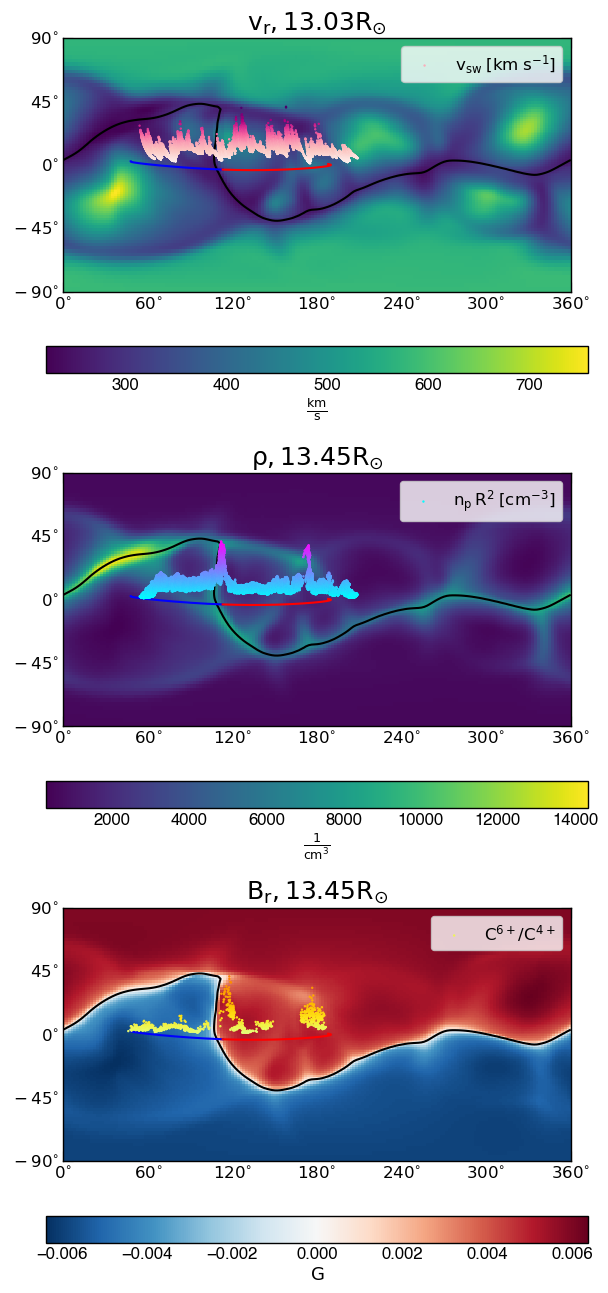

In [11]:
from matplotlib.ticker import NullLocator

fig, axs = plt.subplots(3, sharey='all', tight_layout=True, figsize=[7, 16], gridspec_kw={'hspace':0.2, 'wspace':0.2})
cbar_kwargs = {"orientation": "horizontal"}
r_idx = -18
import astropy.units as u
var = ["vr", "rho", "br"]
titles = [r'$\rm v_r, 13.03 R_{\odot}$', r'$\rm \rho, 13.45 R_{\odot}$', r'$\rm B_r, 13.45 R_{\odot}$']
# find lowest lat value
lat_low = np.min(np.deg2rad(parker.lat))
# polarities
neg = np.where(parker.lon <= 113)[0]
pos = np.where(parker.lon > 113)[0]

for i in range(0, 3):
    ax = axs[i]
    corona_model[var[i]].plot_radial_cut(r_idx, ax=ax, cbar_kwargs=cbar_kwargs)
    corona_model["br"].contour_radial_cut(r_idx, levels=[0], ax=ax, colors="black", zorder=1)
    ax.plot(np.deg2rad(parker.lon[neg]), np.deg2rad(parker.lat[neg]), color='blue', zorder=2)
    ax.plot(np.deg2rad(parker.lon[pos]), np.deg2rad(parker.lat[pos]), color='red', zorder=2)
    ax.set_xticks(np.deg2rad([0, 60, 120, 180, 240, 300, 360]))
    ax.set_yticks(np.deg2rad([-90, -45, 0, 45, 90]))
    ax.set_xticklabels([r'$\rm 0^{\circ}$', r'$\rm 60^{\circ}$', r'$\rm 120^{\circ}$', r'$\rm 180^{\circ}$',
                         r'$\rm 240^{\circ}$', r'$\rm 300^{\circ}$', r'$\rm 360^{\circ}$'])
    ax.set_yticklabels([r'$\rm -90^{\circ}$', r'$\rm -45^{\circ}$', r'$\rm 0^{\circ}$', 
                         r'$\rm 45^{\circ}$', r'$\rm 90^{\circ}$'])
    ax.set_title(titles[i], fontsize=18)
    ax.xaxis.set_minor_locator(NullLocator())
    ax.yaxis.set_minor_locator(NullLocator())

# plot the data
ssize = 0.5
zord = 5
# velocity 
ax = axs[0]
vel = utils.renormalize_data(np.deg2rad(parker.vr), lat_low + np.deg2rad(5), lat_low + np.deg2rad(45))
axs[0].scatter(np.deg2rad(parker.sslon), vel, c = vel, cmap='RdPu', s=ssize, zorder=zord, label=r'$\rm v_{sw} \; [km \; s^{-1}]$')
# ax.set_xticklabels([r'$\rm 0^{\circ}$', r'$\rm 60^{\circ}$', r'$\rm 120^{\circ}$', r'$\rm 180^{\circ}$',
#                          r'$\rm 240^{\circ}$', r'$\rm 300^{\circ}$', r'$\rm 360^{\circ}$'])
# ax.set_yticklabels([r'$\rm -90^{\circ}$', r'$\rm -45^{\circ}$', r'$\rm 0^{\circ}$', 
#                          r'$\rm 45^{\circ}$', r'$\rm 90^{\circ}$'])
axs[0].legend(loc='upper right')

# density
ax = axs[1]
rho = utils.renormalize_data(np.deg2rad(parker.Np), lat_low + np.deg2rad(5), lat_low + np.deg2rad(45))
axs[1].scatter(np.deg2rad(parker.sslon), rho, c = rho, cmap='cool', s=ssize, zorder=zord, label=r'$\rm n_p\, R^2 \; [cm^{-3}]$')
# ax.set_xticklabels([r'$\rm 0^{\circ}$', r'$\rm 60^{\circ}$', r'$\rm 120^{\circ}$', r'$\rm 180^{\circ}$',
#                          r'$\rm 240^{\circ}$', r'$\rm 300^{\circ}$', r'$\rm 360^{\circ}$'])
# ax.set_yticklabels([r'$\rm -90^{\circ}$', r'$\rm -45^{\circ}$', r'$\rm 0^{\circ}$', 
#                          r'$\rm 45^{\circ}$', r'$\rm 90^{\circ}$'])
axs[1].legend(loc='upper right')

# magnetic field
ax = axs[2]
car = utils.renormalize_data(np.deg2rad(his_orbiter.C6C4), lat_low + np.deg2rad(5), lat_low + np.deg2rad(45))
axs[2].scatter(np.deg2rad(his_orbiter.sslon)[630:], car[630:], c=car[630:], cmap='Wistia', s=ssize, zorder=zord, label = r'$\rm C^{6+}/C^{4+}$')
ax.set_xticklabels([r'$\rm 0^{\circ}$', r'$\rm 60^{\circ}$', r'$\rm 120^{\circ}$', r'$\rm 180^{\circ}$',
                         r'$\rm 240^{\circ}$', r'$\rm 300^{\circ}$', r'$\rm 360^{\circ}$'])
ax.set_yticklabels([r'$\rm -90^{\circ}$', r'$\rm -45^{\circ}$', r'$\rm 0^{\circ}$', 
                         r'$\rm 45^{\circ}$', r'$\rm 90^{\circ}$'])
legend = axs[2].legend(loc='upper right')

### SAVE FIGURES 
plt.savefig('figures/fig9.png', bbox_inches='tight')
plt.savefig('eps_figures/fig9.eps', bbox_inches='tight')
plt.savefig('eps_figures/fig9.pdf', bbox_inches='tight')